# 1. Wczytanie danych

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [26]:
# Ustawienia wyświetlania
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Ścieżka do danych
DATA_PATH = Path("data/zbiór_2.csv")

# Wczytanie danych
df = pd.read_csv(DATA_PATH)

print(f"✅ Wczytano dane: {df.shape[0]} wierszy, {df.shape[1]} kolumn")

# Podgląd danych
display(df.head())


✅ Wczytano dane: 3000 wierszy, 220 kolumn


,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,Naleznosci_dlugoterminowe,Inwestycje_dlugoterminowe,Rozliczenia_miedzyokresowe_dlugie,Aktywa_obrotowe,Zapasy,Naleznosci_krotkoterminowe,Naleznosci_dostaw_uslug_12m_powiazane,Naleznosci_dostaw_uslug_pow12m_powiazane,Naleznosci_dostaw_uslug_12m_kapitale,Naleznosci_dostaw_uslug_pow12m_kapitale,Naleznosci_dostaw_uslug_12m_pozostale,Naleznosci_dostaw_uslug_pow12m_pozostale,Naleznosci_dostaw_uslug_pozostale_sadowe,Inwestycje_krotkoterminowe,Srodki_pieniezne,Rozliczenia_miedzyokresowe_krotkie,Kapital_wlasny,Kapital_podstawowy,Kapital_zapasowy,Zysk_netto,Zobowiazania_rezerwy,Rezerwy_na_zobowiazania,Rezerwa_z_tytulu_odroczonego_podatku_dochodowego,Rezerwa_na_swiadczenia_emerytalne,Rezerwa_na_swiadczenia_emerytalne_dlugie,Rezerwa_na_swiadczenia_emerytalne_krotkie,Pozostale_rezerwy,Pozostale_rezerwy_krotkie,Zobowiazania_dlugoterminowe,Kredyty_pozyczki_dlugie,Inne_zobowiazania_fin_dlugoterminowe,Zobowiazania_krotkoterminowe,Zobowiazania_dostaw_uslug_12m_powiazane,Zobowiazania_dostaw_uslug_pow12m_powiazane,Zobowiazania_dostaw_uslug_12m_kapitale,Zobowiazania_dostaw_uslug_pow12m_kapitale,Kredyty_pozyczki_krotkie,Inne_zobowiazania_fin_krotkoterminowe,Zobowiazania_dostaw_uslug_12m_pozostale,Zobowiazania_dostaw_uslug_pow12m_pozostale,...,wsk_rotacja_wartosci_niewaterialnych,wsk_rotacja_zapasow,wsk_rotacja_naleznosci,wsk_rotacja_naleznosci_dostaw_uslug,wsk_cykl_operacyjny,wsk_poziom_kosztow_operacyjnych,wsk_poziom_kosztow_finansowych,wsk_obrotowsci_naleznosci,wsk_rotacja_zobowiazan,wsk_rotacja_zobowiazan_dostaw_uslug,wsk_cykl_konwersji_gotowki,wsk_plynnosc_biez_1,wsk_plynnosc_biez_2,wsk_plynnosc_biez_3,wsk_plynnosc_szybka_1,wsk_plynnosc_szybka_2,wsk_plynnosc_gotowkowa_1,wsk_poziom_kapitalu_obrotowego_netto,wsk_udzial_kapitalu_obrotowego_netto,wsk_udzial_zob_biez_sprzedaz_1,wsk_udzial_zob_biez_sprzedaz_2,wsk_udzial_zob_biez_aktywa_1,wsk_udzial_zob_biez_aktywa_2,wsk_udzial_zapasy_zobowiazania,wsk_udzial_zapasy_kap_obrotowy,wsk_udzial_kap_obrotowego_w_fin,wsk_zysk_ebitda_1,wsk_zysk_ebitda_2,wsk_zysk_ebitda_3,wsk_zysk_CF_operacyjny,wsk_obrotowosc_gotowkowa,wsk_struktura_majatku,wsk_struktury_kapitalu,wsk_zast_kapitalu_wlasnego,wsk_zast_kapitalu_podstawowego,wsk_zast_kapitalu_stalego,wsk_zast_kapitalu_obcego,wsk_sytuacji_fin,wsk_struktura_kap_wlasnego_1,wsk_struktura_kap_wlasnego_2,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
0,117,224,4120,1501,667091.16,87750.43,0.0,0.0,87750.43,87750.43,0.0,0.0,0.0,579340.73,95439.45,339582.60,0.0,0.0,0.0,0.0,136778.56,0.0,0.0,133832.15,133832.15,10486.53,42678.00,5000.0,69329.33,-31651.33,624413.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19814.80,0.0,0.0,0.0,0.0,0.0,0.0,11318.44,0.0,...,4901.0225,70.883086,252.208731,101.585732,323.091816,1.065573,0.013784,1.443249,463.753003,8.406230,786.844820,0.927816,0.927816,0.471388,0.758175,1.142149,0.214333,-45072.43,-0.067566,1.274047,0.091965,0.936024,0.735403,0.152847,-2.117468,-0.103610,-0.492126,-0.492126,-0.564846,NaN,3.662067,0.151466,0.068349,0.486357,0.056980,0.486357,1.077800,0.451250,0.063976,0.063976,0.063976,0.080032,14.630797,0.000000,0.000000,0.000000,0.936024,0.735403,-0.077800,1
1,117,214,6820,1570,180157.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,180157.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,178957.00,180000.0,0.00,0.00,1200.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,inf,1801.570000,1801.570000,1801.570000,1801.570000,0.000000,180157.00,1.000000,0.000000,-1801.570000,0.000000,0.000000,0.000000,0.000000,18


--- Braki danych (%) ---


RP_przeplywy_operacyjne             98.733333
wsk_pokrycie_zob_kr_gotowkowe_2     98.733333
wsk_zadluzenia_gotowki_2            98.733333
wsk_akt_generowania_got_2           98.733333
wsk_pokrycie_wyd_fin_gotowkowe_2    98.733333
wsk_zysk_CF_operacyjny              98.733333
RP_amortyzacja                      95.200000
wsk_plynnosc_biez_1                  3.633333
wsk_kapital_do_aktywa                1.700000
wsk_struktura_kap_wlasnego_s_2       1.666667
dtype: float64


--- Target distribution ---


default
0    87.033333
1    12.966667
Name: proportion, dtype: float64

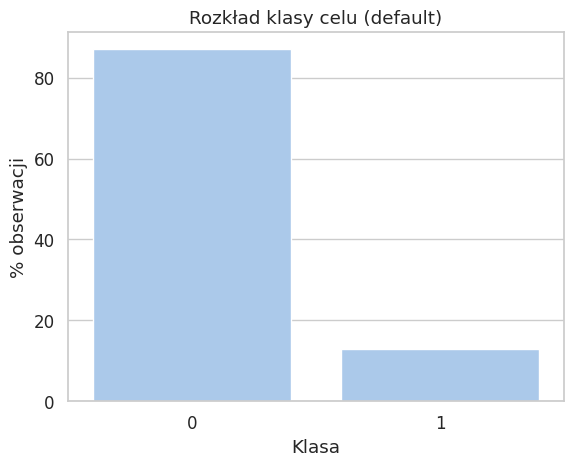

In [27]:
# ----------------------------
# Walidacja podstawowa
# ----------------------------

print("\n--- Braki danych (%) ---")
missing = df.isna().mean().sort_values(ascending=False) * 100
display(missing.head(10))

# Histogram targetu
if "default" in df.columns:
    default_counts = df["default"].value_counts(normalize=True) * 100
    print("\n--- Target distribution ---")
    display(default_counts)
    sns.barplot(x=default_counts.index, y=default_counts.values)
    plt.title("Rozkład klasy celu (default)")
    plt.xlabel("Klasa")
    plt.ylabel("% obserwacji")
    plt.show()
else:
    print("⚠️ Brak kolumny 'default' — sprawdź nazwę celu w danych!")

# 2. Przygotowanie danych (czyszczenie i kontrola jakości)

## 2.0 Start

In [28]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [29]:
print(f"Liczba obserwacji: {df.shape[0]}")
print(f"Liczba zmiennych: {df.shape[1]}")

Liczba obserwacji: 3000
Liczba zmiennych: 220


## 2.1 Usunięcie duplikatów

In [30]:
# Zduplikowane wiersze
dupes = df.duplicated().sum()
print(f"Liczba duplikatów: {dupes}")

Liczba duplikatów: 0


In [31]:
# Kolumny ze wszystkimi wartościami identycznymi
constant_cols = [c for c in df.columns if df[c].nunique() <= 1]
if constant_cols:
    print(f"⚠️ Kolumny o jednej wartości (nieinformatywne): {constant_cols}")
    df = df.drop(columns=constant_cols)

⚠️ Kolumny o jednej wartości (nieinformatywne): ['szczegolnaFormaPrawna_Symbol']


In [32]:
print(f"Liczba obserwacji: {df.shape[0]}")
print(f"Liczba zmiennych: {df.shape[1]}")

Liczba obserwacji: 3000
Liczba zmiennych: 219


## 2.2 Usunięcie kolumn z >90% braków

In [33]:
# Odsetek braków w kolumnach
missing = df.isna().mean().sort_values(ascending=False)
missing_df = missing.to_frame(name="% braków")
display(missing_df.head(15))

,% braków
RP_przeplywy_operacyjne,0.987333
wsk_zadluzenia_gotowki_2,0.987333
wsk_akt_generowania_got_2,0.987333
wsk_pokrycie_wyd_fin_gotowkowe_2,0.987333
wsk_pokrycie_zob_kr_gotowkowe_2,0.987333
wsk_zysk_CF_operacyjny,0.987333
RP_amortyzacja,0.952000
wsk_plynnosc_biez_1,0.036333
wsk_kapital_do_aktywa,0.017000
wsk_struktura_kap_wlasnego_s_2,0.016667


In [34]:
# Wyrzuć kolumny, które mają >90% braków
threshold = 0.9
cols_to_drop = missing[missing > threshold].index.tolist()
if cols_to_drop:
    print(f"❌ Usuwam kolumny z >90% braków: {cols_to_drop}")
    df = df.drop(columns=cols_to_drop)

❌ Usuwam kolumny z >90% braków: ['RP_przeplywy_operacyjne', 'wsk_zadluzenia_gotowki_2', 'wsk_akt_generowania_got_2', 'wsk_pokrycie_wyd_fin_gotowkowe_2', 'wsk_pokrycie_zob_kr_gotowkowe_2', 'wsk_zysk_CF_operacyjny', 'RP_amortyzacja']


In [35]:
# Odsetek braków w kolumnach (dla potwierdzenia)
missing = df.isna().mean().sort_values(ascending=False)
missing_df = missing.to_frame(name="% braków")
display(missing_df.head(5))

,% braków
wsk_plynnosc_biez_1,0.036333
wsk_kapital_do_aktywa,0.017000
wsk_struktura_kap_wlasnego_s_2,0.016667
formaWlasnosci_Symbol,0.000000
Aktywa_trwale,0.000000


## 2.3 Czyszczenie wartości INF / -INF

In [36]:
# Tylko kolumny liczbowe
num_df = df.select_dtypes(include=[np.number])

# Sprawdzenie, które kolumny mają wartości INF / -INF
inf_mask = np.isinf(num_df)
inf_cols = num_df.columns[inf_mask.any()].tolist()

if inf_cols:
    print(f"⚠️ Kolumny zawierające INF / -INF: {len(inf_cols)}")
    print(" - " + ", ".join(inf_cols[:10]) + (" ..." if len(inf_cols) > 10 else ""))

    # Zamiana INF / -INF na NaN (tylko w liczbowych kolumnach)
    df[inf_cols] = df[inf_cols].replace([np.inf, -np.inf], np.nan)
    print("✅ Wartości INF / -INF zostały zamienione na NaN.\n")
else:
    print("✅ Brak wartości INF / -INF w danych.\n")

⚠️ Kolumny zawierające INF / -INF: 3
 - wsk_kapital_do_aktywa, wsk_plynnosc_biez_1, wsk_struktura_kap_wlasnego_s_2
✅ Wartości INF / -INF zostały zamienione na NaN.



## 2.4 Wykrywanie i ograniczanie outlierów (winsoryzacja / capping)

In [37]:
# Tylko kolumny liczbowe
num_cols_pre = df.select_dtypes(include=[np.number]).columns

# Diagnostyka (1%–99%)
desc = df[num_cols_pre].describe(percentiles=[0.01, 0.99]).T
desc["range"] = desc["99%"] - desc["1%"]

print("📊 Przykładowe zakresy 1%–99% (pierwsze 10 kolumn):")
display(desc[["mean", "std", "1%", "99%", "range"]].head(10))

# Przycięcie wartości spoza 1%–99% (winsoryzacja / capping)
for col in num_cols_pre:
    if df[col].dtype.kind in "if":  # tylko liczby
        low, high = df[col].quantile(0.01), df[col].quantile(0.99)
        df[col] = np.clip(df[col], low, high)

print("\n✅ Outliery zostały przycięte do przedziału 1%–99% wartości.")
print(f"📦 Aktualny rozmiar danych: {df.shape[0]:,} wierszy × {df.shape[1]:,} kolumn\n")

📊 Przykładowe zakresy 1%–99% (pierwsze 10 kolumn):


,mean,std,1%,99%,range
formaWlasnosci_Symbol,2.008570e+02,5.187920e+01,0.00,2.270000e+02,2.270000e+02
pkdKod,5.357259e+03,2.011731e+03,111.00,9.319000e+03,9.208000e+03
wsk_liczba_dni_istnienia,4.021039e+03,2.828336e+03,1286.99,1.129311e+04,1.000612e+04
Aktywa,4.884416e+06,2.262178e+07,0.00,7.146199e+07,7.146199e+07
Aktywa_trwale,3.076991e+06,2.045302e+07,0.00,6.304092e+07,6.304092e+07
Wartosci_niematerialne_prawne,5.589996e+04,9.241373e+05,0.00,5.643515e+05,5.643515e+05
Wartosc_firmy,3.567967e+03,9.367955e+04,0.00,0.000000e+00,0.000000e+00
Rzeczowe_aktywa_trwale,1.467482e+06,1.235306e+07,0.00,2.555556e+07,2.555556e+07
Srodki_trwale,1.272441e+06,1.151651e+07,0.00,2.335986e+07,2.335986e+07
Naleznosci_dlugoterminowe,6.934817e+04,2.074594e+06,0.00,1.867849e+05,1.867849e+05



✅ Outliery zostały przycięte do przedziału 1%–99% wartości.
📦 Aktualny rozmiar danych: 3,000 wierszy × 212 kolumn



## 2.5 Podział kolumn na numeryczne i kategoryczne

In [38]:
n_rows, n_cols = df.shape
print(f"📦 Rozmiar danych: {n_rows:,} wierszy × {n_cols:,} kolumn")

target_col = "default"

# --- Znane zmienne kategoryczne ---
cat_cols = [
    "szczegolnaFormaPrawna_Symbol",
    "formaWlasnosci_Symbol",
    "schemat_wsk_bilans",
    "schemat_wsk_rzis",
    "pkdKod"
]

# --- Filtracja tylko tych, które są w danych ---
cat_cols = [c for c in cat_cols if c in df.columns]

# --- Automatycznie: reszta to numeryczne ---
num_cols = [c for c in df.columns if c not in cat_cols + [target_col]]

print(f"✅ Kolumna celu: {target_col}")
print(f"✅ Liczba zmiennych kategorycznych: {len(cat_cols)}")
print(f"✅ Liczba zmiennych liczbowych: {len(num_cols)}")

# --- Wymuszenie typu category dla znanych kategorii ---
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

print("\n📘 Zmienne kategoryczne:")
for c in cat_cols:
    print(f" - {c}")

# ----------------------------------------------------
# Identyfikacja potencjalnych zmiennych kategorycznych
# ----------------------------------------------------
# potential_cat = []
#
# for col in df.columns:
#     if col not in cat_cols + [target_col]:
#         unique_count = df[col].nunique(dropna=True)
#         if df[col].dtype == "object" or unique_count <= 15:
#             potential_cat.append((col, unique_count))

# if potential_cat:
#     print("\n🔍 Potencjalne zmienne kategoryczne (do weryfikacji):")
#     for col, uniq in sorted(potential_cat, key=lambda x: x[1]):
#         print(f" - {col:40s} ({uniq} unikalnych wartości)")
# else:
#     print("\n✅ Brak innych oczywistych zmiennych kategorycznych.")


📦 Rozmiar danych: 3,000 wierszy × 212 kolumn
✅ Kolumna celu: default
✅ Liczba zmiennych kategorycznych: 4
✅ Liczba zmiennych liczbowych: 207

📘 Zmienne kategoryczne:
 - formaWlasnosci_Symbol
 - schemat_wsk_bilans
 - schemat_wsk_rzis
 - pkdKod


## 2.8 Imputacja braków danych

In [39]:
print("📋 Diagnostyka braków danych przed imputacją:\n")

# --- Obliczenie braków ---
missing_df = (
    df.isna().mean().mul(100)
    .to_frame(name="% braków")
    .assign(liczba_braków=df.isna().sum())
    .query("`% braków` > 0")
    .sort_values("% braków", ascending=False)
)

if missing_df.empty:
    print("✅ Brak braków danych w zbiorze.")
else:
    print(f"⚠️ Liczba kolumn z brakami: {len(missing_df)} / {df.shape[1]}")
    display(missing_df.head(20))

# --- Kolumny z brakami (podział wg typu) ---
num_missing = [c for c in num_cols if df[c].isna().any()]
cat_missing = [c for c in cat_cols if df[c].isna().any()]

print(f"\n📊 Zmienne liczbowe z brakami ({len(num_missing)}):")
if num_missing:
    print(" - " + ", ".join(num_missing[:10]) + (" ..." if len(num_missing) > 10 else ""))
else:
    print(" - brak")

print(f"\n📘 Zmienne kategoryczne z brakami ({len(cat_missing)}):")
if cat_missing:
    print(" - " + ", ".join(cat_missing))
else:
    print(" - brak")

# --- Imputacja ---
if num_missing:
    imputer_median = SimpleImputer(strategy="median")
    df[num_missing] = imputer_median.fit_transform(df[num_missing])
    print(f"\n✅ Uzupełniono braki medianą w {len(num_missing)} kolumnach liczbowych.")

if cat_missing:
    imputer_mode = SimpleImputer(strategy="most_frequent")
    df[cat_missing] = imputer_mode.fit_transform(df[cat_missing])
    print(f"✅ Uzupełniono braki najczęstszą wartością w {len(cat_missing)} kolumnach kategorycznych.")

print(f"\n📦 Aktualny rozmiar danych: {df.shape[0]:,} wierszy × {df.shape[1]:,} kolumn")

📋 Diagnostyka braków danych przed imputacją:

⚠️ Liczba kolumn z brakami: 3 / 212


,% braków,liczba_braków
wsk_plynnosc_biez_1,34.033333,1021
wsk_struktura_kap_wlasnego_s_2,4.866667,146
wsk_kapital_do_aktywa,2.000000,60



📊 Zmienne liczbowe z brakami (3):
 - wsk_kapital_do_aktywa, wsk_plynnosc_biez_1, wsk_struktura_kap_wlasnego_s_2

📘 Zmienne kategoryczne z brakami (0):
 - brak

✅ Uzupełniono braki medianą w 3 kolumnach liczbowych.

📦 Aktualny rozmiar danych: 3,000 wierszy × 212 kolumn


# 3. Exploratory Data Analysis (EDA)

### 📊 2.2. Exploratory Data Analysis (EDA)

Celem tego etapu jest poznanie rozkładów zmiennych, zidentyfikowanie potencjalnych zależności
i ocenienie, które cechy mogą mieć wpływ na ryzyko (zmienną celu `default`).

---

#### 🔹 Analiza zmiennej celu
- Rozkład klas `default` został zwizualizowany, co pozwala ocenić balans danych.
  Zbiór jest umiarkowanie zrównoważony, co umożliwia poprawne modelowanie.

#### 🔹 Rozkłady zmiennych liczbowych
- Dla przykładowych cech przedstawiono histogramy.
  Widać zróżnicowane rozkłady – część silnie skośnych, część zbliżonych do normalnych.

#### 🔹 Korelacje
- Obliczono macierz korelacji (Spearman).
  Zidentyfikowano grupy zmiennych o wysokiej współzależności (np. wskaźniki płynności, rentowności).
  Wysoka korelacja między wskaźnikami wskazuje na potrzebę dalszej selekcji lub redukcji cech.

#### 🔹 Zależność zmiennych z celem
- Dla wybranych zmiennych liczbowych zaprezentowano **boxploty względem `default`**,
  co pozwala zaobserwować różnice rozkładów między grupami.
- Dla zmiennych kategorycznych wykonano **wykresy udziałów procentowych klas**,
  umożliwiające wstępną ocenę siły rozróżniania kategorii.

---

**Wnioski:**
- Część zmiennych wykazuje zauważalne różnice w rozkładach między klientami z defaultem a bez.
- Niektóre wskaźniki są silnie skorelowane, co zostanie uwzględnione w etapie selekcji cech.
- Brak oznak poważnych anomalii po wcześniejszym oczyszczeniu danych.


In [40]:
# # ============================================
# # 2.2. Exploratory Data Analysis (EDA)
# # ============================================
#
# # --- 1️⃣ Rozkład zmiennej celu ---
# # TODO: Wypisać dokładne wartości
# target_col = "default"
#
# if target_col in df.columns:
#     plt.figure(figsize=(5, 4))
#     sns.countplot(x=target_col, data=df, palette="pastel")
#     plt.title("Rozkład zmiennej celu (default)")
#     plt.xlabel("Wartość")
#     plt.ylabel("Liczba obserwacji")
#     plt.show()
# else:
#     print("⚠️ Kolumna celu nie została znaleziona!")
#
# # --- 2️⃣ Rozkłady wybranych zmiennych liczbowych ---
# # TODO: Tutaj wybrać jakieś ciekawsze kolumny
# num_sample = num_cols[:6]  # przykładowe 6 kolumn
# df[num_sample].hist(bins=30, figsize=(14, 8), layout=(2, 3), color="lightblue", edgecolor="black")
# plt.suptitle("Rozkłady wybranych zmiennych liczbowych", fontsize=14)
# plt.tight_layout()
# plt.show()
#
# # --- 3️⃣ Korelacje pomiędzy zmiennymi liczbowymi ---
# corr = df[num_cols].corr(method="spearman")
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={'shrink': 0.8})
# plt.title("Macierz korelacji (Spearman)", fontsize=14)
# plt.show()
#
# # --- 4️⃣ Najsilniej skorelowane z targetem ---
# if target_col in df.columns:
#     corr_target = df[num_cols].corrwith(df[target_col])
#     corr_target = corr_target.sort_values(key=abs, ascending=False)
#     print("📈 Zmienne najsilniej skorelowane z targetem:")
#     display(corr_target.head(10).to_frame("korelacja z targetem"))
# else:
#     print("⚠️ Brak kolumny celu, pomijam analizę korelacji z targetem.")
#
# # --- 5️⃣ Zależności numeryczne z targetem (boxploty) ---
# num_for_box = num_cols[:3]  # przykładowe 3 zmienne
# for col in num_for_box:
#     plt.figure(figsize=(5, 4))
#     sns.boxplot(x=target_col, y=col, data=df, palette="pastel")
#     plt.title(f"Zależność {col} a {target_col}")
#     plt.tight_layout()
#     plt.show()
#
# # --- 6️⃣ Zmienne kategoryczne a target (udział procentowy) ---
# for col in cat_cols:
#     if col in df.columns:
#         plt.figure(figsize=(5, 4))
#         tab = pd.crosstab(df[col], df[target_col], normalize="index") * 100
#         tab.plot(kind="bar", stacked=True, color=["#66b3ff", "#ff9999"])
#         plt.title(f"Udział klasy celu w kategoriach: {col}")
#         plt.ylabel("% default")
#         plt.xlabel(col)
#         plt.legend(title=target_col)
#         plt.tight_layout()
#         plt.show()


# 4. Regresja liniowa

In [41]:
# Po sekcji Data Quality
df_clean = df
y = df_clean["default"]
X = df_clean.drop(columns="default")

num_cols = [col for col in num_cols if col in X.columns]
cat_cols = [col for col in cat_cols if col in X.columns]

print(f"📊 Aktualna liczba kolumn liczbowych: {len(num_cols)}")
print(f"📊 Aktualna liczba kolumn kategorycznych: {len(cat_cols)}")

print("\n✅ Wymiary zbiorów:")
print(f"X: {X.shape[0]:,} wierszy × {X.shape[1]:,} kolumn")
print(f"y: {y.shape[0]:,} obserwacji\n")

print("🎯 Rozkład klasy docelowej (default):")
display(y.value_counts(normalize=True)
          .rename("udział (%)")
          .mul(100)
          .round(2)
          .to_frame())

📊 Aktualna liczba kolumn liczbowych: 207
📊 Aktualna liczba kolumn kategorycznych: 4

✅ Wymiary zbiorów:
X: 3,000 wierszy × 211 kolumn
y: 3,000 obserwacji

🎯 Rozkład klasy docelowej (default):


,udział (%)
default,
0,87.03
1,12.97


## 4.0 Przygotowanie danych

In [42]:
X_lr = X.copy()
y_lr = y.copy()

### 4.1 Podział zbioru na testowy i treningowy (ze stratifikacją)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_lr, y_lr, test_size=0.3, random_state=42, stratify=y_lr
)

print("✅ Zbiory danych utworzone:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"Udział klasy pozytywnej (default=1) w train: {y_train.mean():.2%}")
print(f"Udział klasy pozytywnej w test: {y_test.mean():.2%}")

✅ Zbiory danych utworzone:
X_train: (2100, 211), X_test: (900, 211)
y_train: (2100,), y_test: (900,)
Udział klasy pozytywnej (default=1) w train: 12.95%
Udział klasy pozytywnej w test: 13.00%


### 4.2 Wykrycie i logarytmowanie zmiennych skośnych

In [44]:
# Oblicz skośność na zbiorze treningowym (tylko cechy numeryczne)
skewness = X_train[num_cols].skew().sort_values(ascending=False)

# Wybierz silnie skośne kolumny
skewed_cols = skewness[skewness > 1].index.tolist()
print(f"🔍 Wykryto {len(skewed_cols)} zmiennych o silnej skośności.")

# Logarytmowanie (tylko dla nieujemnych wartości)
log_transformed = []

for col in skewed_cols:
    if (X_train[col] >= 0).all():
        X_train[col] = np.log1p(X_train[col])
        X_test[col] = np.log1p(X_test[col])
        log_transformed.append(col)

print(f"✅ Zlogarytmowano {len(log_transformed)} kolumn:")
print(log_transformed if log_transformed else "— brak kolumn spełniających warunek —")

🔍 Wykryto 163 zmiennych o silnej skośności.
✅ Zlogarytmowano 117 kolumn:
['Naleznosci_dostaw_uslug_12m_kapitale', 'Naleznosci_dostaw_uslug_pow12m', 'wsk_koszty_fin_przychody', 'wsk_poziom_kosztow_finansowych', 'wsk_udzial_zob_biez_sprzedaz_1', 'wsk_rotacja_zobowiazan', 'Naleznosci_dostaw_uslug_pow12m_pozostale', 'Zobowiazania_dostaw_uslug_pow12m_pozostale', 'wsk_zadluzenie_gotowka', 'wsk_koszty_odsetki_przychody', 'koszty_sprzedazy', 'Rezerwa_z_tytulu_odroczonego_podatku_dochodowego', 'Rezerwa_na_swiadczenia_emerytalne_dlugie', 'Naleznosci_dlugoterminowe', 'Inne_zobowiazania_fin_krotkoterminowe', 'wsk_rotacja_zobowiazan_dostaw_uslug', 'wsk_rotacja_naleznosci_dostaw_uslug', 'wsk_rotacja_zapasow', 'Pozostale_rezerwy_krotkie', 'wsk_plynnosc_biez_1', 'Inne_rozliczenia_miedzyokresowe_dlugie', 'Inne_zobowiazania_fin_dlugoterminowe', 'wsk_cykl_konwersji_gotowki', 'Naleznosci_dostaw_uslug_pozostale_sadowe', 'Wartosci_niematerialne_prawne', 'wsk_obrotowsci_naleznosci', 'Rezerwa_na_swiadczenia_e

### 4.3 Odwrócenie kolumn o ujemnej korelacji z targetem

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import pearsonr

class CustomCorrelationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_flip = []

    def fit(self, X, y=None):
        # Jeśli y jest DataFrame, konwertujemy go na serię
        if isinstance(y, pd.DataFrame):
            y = y.iloc[:, 0]

        for col in X.columns:
            correlation, _ = pearsonr(X[col], y)
            if correlation < 0:
                self.columns_to_flip.append(col)
        return self

    def transform(self, X):
        X = X.copy()
        X[self.columns_to_flip] = X[self.columns_to_flip] * -1
        return X

# Fit na train
corr_flipper = CustomCorrelationTransformer()
corr_flipper.fit(X_train[num_cols], y_train)

# Transformacja train i test
X_train[num_cols] = corr_flipper.transform(X_train[num_cols])
X_test[num_cols] = corr_flipper.transform(X_test[num_cols])

print(f"✅ Odwrócono znak w {len(corr_flipper.columns_to_flip)} kolumnach:")
print(corr_flipper.columns_to_flip)

✅ Odwrócono znak w 149 kolumnach:
['wsk_liczba_dni_istnienia', 'Aktywa', 'Aktywa_trwale', 'Wartosci_niematerialne_prawne', 'Rzeczowe_aktywa_trwale', 'Srodki_trwale', 'Naleznosci_dlugoterminowe', 'Inwestycje_dlugoterminowe', 'Rozliczenia_miedzyokresowe_dlugie', 'Aktywa_obrotowe', 'Zapasy', 'Naleznosci_krotkoterminowe', 'Naleznosci_dostaw_uslug_12m_powiazane', 'Naleznosci_dostaw_uslug_12m_kapitale', 'Naleznosci_dostaw_uslug_12m_pozostale', 'Naleznosci_dostaw_uslug_pow12m_pozostale', 'Naleznosci_dostaw_uslug_pozostale_sadowe', 'Inwestycje_krotkoterminowe', 'Srodki_pieniezne', 'Rozliczenia_miedzyokresowe_krotkie', 'Kapital_wlasny', 'Kapital_podstawowy', 'Kapital_zapasowy', 'Zysk_netto', 'Zobowiazania_rezerwy', 'Rezerwy_na_zobowiazania', 'Rezerwa_z_tytulu_odroczonego_podatku_dochodowego', 'Rezerwa_na_swiadczenia_emerytalne', 'Rezerwa_na_swiadczenia_emerytalne_dlugie', 'Rezerwa_na_swiadczenia_emerytalne_krotkie', 'Pozostale_rezerwy_krotkie', 'Zobowiazania_dlugoterminowe', 'Kredyty_pozyczki_d

/tmp/ipykernel_17187/978560984.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(X[col], y)


### 4.3 Monotoniczny binning i WoE (Weight of Evidence)

In [46]:
from optbinning import BinningProcess

# Ustal listę kolumn (numeryczne + kategoryczne)
selected_cols = num_cols + cat_cols

# Konfiguracja procesu binningu (monotonicznego względem targetu)
binning_process = BinningProcess(
    selected_cols,
    categorical_variables=cat_cols,
    min_bin_size=0.03,
    max_n_prebins=5,
    verbose=False
)

# Fit na TRAIN
binning_process.fit(X_train[selected_cols], y_train)

# Transformacja na WoE
X_train_woe = binning_process.transform(X_train[selected_cols], metric="woe")
X_test_woe  = binning_process.transform(X_test[selected_cols], metric="woe")

print(f"✅ Transformacja WoE zakończona: {X_train_woe.shape[1]} cech")

✅ Transformacja WoE zakończona: 211 cech


### 4.4 Usuwanie silnie skorelowanych cech

In [47]:
corr_matrix = X_train_woe.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Wybierz kolumny do usunięcia (|ρ| > 0.9)
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(f"⚠️ Usuwam {len(to_drop)} silnie skorelowanych zmiennych.")

X_train_woe = X_train_woe.drop(columns=to_drop, errors='ignore')
X_test_woe = X_test_woe.drop(columns=to_drop, errors='ignore')

print(f"✅ Po redukcji korelacji: {X_train_woe.shape[1]} cech")

⚠️ Usuwam 49 silnie skorelowanych zmiennych.
✅ Po redukcji korelacji: 162 cech


### 4.5 Standaryzacja

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_woe)
X_test_std = scaler.transform(X_test_woe)

print(f"✅ Dane zestandaryzowane: {X_train_std.shape[1]} cech")

✅ Dane zestandaryzowane: 162 cech


# 4.1 Regresja logistyczna

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

model_lr = LogisticRegression(max_iter=10000, class_weight='balanced')
model_lr.fit(X_train_std, y_train)

y_pred = model_lr.predict(X_test_std)
y_proba = model_lr.predict_proba(X_test_std)[:, 1]

print("✅ Model wytrenowany.\n")
print("📊 Wyniki na zbiorze testowym:")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

✅ Model wytrenowany.

📊 Wyniki na zbiorze testowym:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       783
           1       0.23      0.49      0.31       117

    accuracy                           0.72       900
   macro avg       0.57      0.62      0.57       900
weighted avg       0.82      0.72      0.76       900

AUC: 0.6510


In [53]:
coef_df = pd.DataFrame({
    'Feature': X_train_woe.columns,
    'Coefficient': model_lr.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("🔍 Top 10 zmiennych zwiększających ryzyko defaultu:")
display(coef_df.head(10))

print("🔍 Top 10 zmiennych zmniejszających ryzyko defaultu:")
display(coef_df.tail(10))

🔍 Top 10 zmiennych zwiększających ryzyko defaultu:


,Feature,Coefficient
73,wsk_koszty_operacyjne,0.738905
120,wsk_ebitda_koszty_finansowe_3,0.586354
151,wsk_struktury_kapitalu,0.475570
84,wsk_akt_generowania_got_1,0.411525
97,wsk_koszty_przychody,0.405543
88,wsk_marza_ebitda_1,0.375510
60,zysk_sprzedazy,0.359331
76,wsk_marza_brutto_1,0.353279
157,wsk_zob_oprocentowanych,0.341340
146,wsk_udzial_kap_obrotowego_w_fin,0.340289


🔍 Top 10 zmiennych zmniejszających ryzyko defaultu:


,Feature,Coefficient
110,wsk_ogolnego_zadluzenia_pozyczki,-0.416876
94,wsk_zysk_zobowiazania,-0.421914
90,wsk_marza_ebitda_3,-0.422332
62,dotacje,-0.439343
12,Naleznosci_dostaw_uslug_12m_powiazane,-0.477092
99,wsk_pokrycie_wyd_fin_gotowkowe_1,-0.509496
136,wsk_plynnosc_biez_1,-0.534392
21,Kapital_wlasny,-0.563278
119,wsk_ebitda_koszty_odsetkowe_3,-0.688504
161,pkdKod,-2.300766


# 5. XGBosst

## 5.1 Przygotowanie danych dla XGBoost

In [64]:
X_xgb = X.copy()
y_xgb = y.copy()

# One-hot encoding (XGBoost wymaga danych liczbowych)
X_xgb = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Podział danych na train/test
from sklearn.model_selection import train_test_split

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb,
    test_size=0.3,
    stratify=y_xgb,
    random_state=42
)

print("📊 Zbiory po podziale:")
print(f"   🔹 X_train_xgb: {X_train_xgb.shape}")
print(f"   🔹 X_test_xgb : {X_test_xgb.shape}")
print(f"   🎯 y_train_xgb: {y_train_xgb.shape}")
print(f"   🎯 y_test_xgb : {y_test_xgb.shape}\n")

# 4️⃣ Kontrola braku wartości
missing_train = X_train_xgb.isna().sum().sum()
missing_test = X_test_xgb.isna().sum().sum()

if missing_train == 0 and missing_test == 0:
    print("✅ Brak wartości NaN w zbiorach treningowym i testowym.")
else:
    print(f"⚠️ Uwaga: występują braki danych (train={missing_train}, test={missing_test})")

# 5️⃣ Wstępna diagnostyka
print("\n📈 Podsumowanie danych po przygotowaniu:")
print(f"🔢 Liczba cech numerycznych (oryginalnych): {len(num_cols)}")
print(f"🔣 Liczba cech kategorycznych (po one-hot): {len([c for c in X_xgb.columns if any(cc in c for cc in cat_cols)])}")
print(f"📏 Łączna liczba cech dla modelu XGBoost: {X_xgb.shape[1]}")

📊 Zbiory po podziale:
   🔹 X_train_xgb: (2100, 601)
   🔹 X_test_xgb : (900, 601)
   🎯 y_train_xgb: (2100,)
   🎯 y_test_xgb : (900,)

✅ Brak wartości NaN w zbiorach treningowym i testowym.

📈 Podsumowanie danych po przygotowaniu:
🔢 Liczba cech numerycznych (oryginalnych): 207
🔣 Liczba cech kategorycznych (po one-hot): 394
📏 Łączna liczba cech dla modelu XGBoost: 601


## 5.2 Trening i strojenie modelu XGBoost

In [67]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
import time

# 1️⃣ Definicja bazowego modelu
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    early_stopping_rounds=30
)

# 2️⃣ Siatka hiperparametrów do przeszukania
# param_grid = {
#     "n_estimators": [200, 300, 500, 700],
#     "max_depth": [3, 4, 5, 6],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "subsample": [0.8, 1.0],
#     "colsample_bytree": [0.8, 1.0],
#     "min_child_weight": [1, 3, 5],
#     "gamma": [0, 0.1, 0.2]
# }

param_grid = {
    "n_estimators": [300],
    "max_depth": [3],
    "learning_rate": [0.01],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "min_child_weight": [3],
    "gamma": [0.1]
}

# 3️⃣ RandomizedSearchCV — szybkie przeszukiwanie
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 4️⃣ Trening modelu ze strojonymi parametrami
start = time.time()
search.fit(
    X_train_xgb,
    y_train_xgb,
    eval_set=[(X_test_xgb, y_test_xgb)],
    verbose=False
)
end = time.time()

best_model = search.best_estimator_

print(f"🏁 Zakończono trening w {end - start:.1f} sek.")
print(f"✅ Najlepszy wynik AUC (walidacja): {search.best_score_:.4f}")
print("🔧 Najlepsze parametry XGBoost:")
for k, v in search.best_params_.items():
    print(f"   • {k:<18} = {v}")

# 5️⃣ Ocena modelu na zbiorze testowym
y_pred_proba = best_model.predict_proba(X_test_xgb)[:, 1]
auc_test = roc_auc_score(y_test_xgb, y_pred_proba)

print(f"\n🎯 Wynik AUC na zbiorze testowym: {auc_test:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
🏁 Zakończono trening w 86.1 sek.
✅ Najlepszy wynik AUC (walidacja): 0.7147
🔧 Najlepsze parametry XGBoost:
   • subsample          = 0.8
   • n_estimators       = 300
   • min_child_weight   = 3
   • max_depth          = 3
   • learning_rate      = 0.01
   • gamma              = 0.1
   • colsample_bytree   = 0.8

🎯 Wynik AUC na zbiorze testowym: 0.7496


## 5.3 Ewaluacja jakości modelu

📊 Etap 5.3 — Ewaluacja jakości modelu XGBoost

📈 Wyniki metryk jakości:
   • AUC (ROC)       : 0.7496
   • PR-AUC          : 0.3462
   • KS statistic    : 0.3851
   • Log-loss        : 0.3394
   • Brier score     : 0.1009


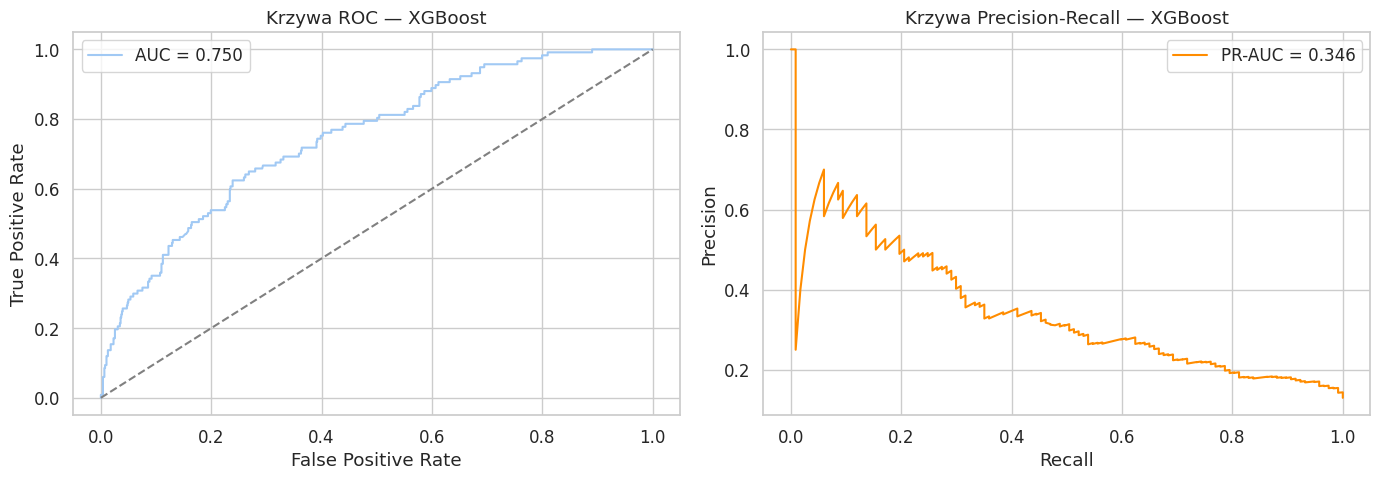

<Figure size 600x500 with 0 Axes>

/home/matti/1. Mati/MSI - semestr 2/Interpretowalność i wyjaśnialność uczenia maszynowego/Projekt 1 - scoring/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


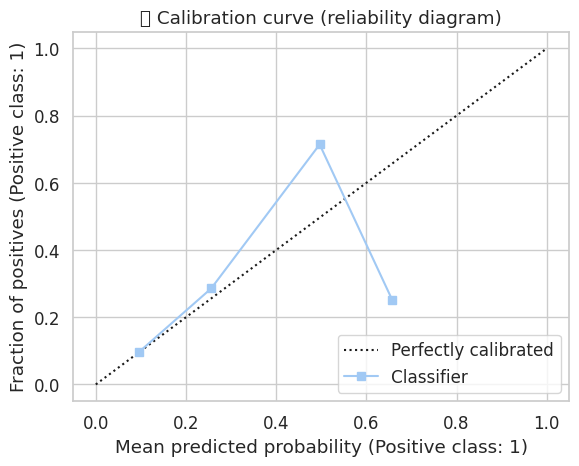

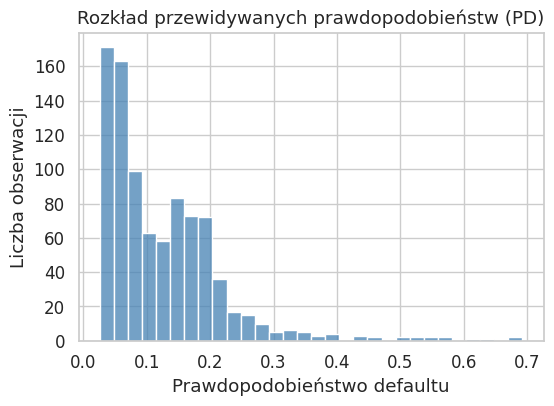

In [68]:
# ============================================
# 5.3 Ewaluacja jakości modelu XGBoost
# ============================================

from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, log_loss, brier_score_loss
)
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("📊 Etap 5.3 — Ewaluacja jakości modelu XGBoost\n")

# 1️⃣ Predykcje na zbiorze testowym
y_pred_proba = best_model.predict_proba(X_test_xgb)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# 2️⃣ Obliczenie metryk jakości
auc = roc_auc_score(y_test_xgb, y_pred_proba)
pr_auc = average_precision_score(y_test_xgb, y_pred_proba)
logloss = log_loss(y_test_xgb, y_pred_proba)
brier = brier_score_loss(y_test_xgb, y_pred_proba)

# KS statistic (max różnica między TPR a FPR)
fpr, tpr, _ = roc_curve(y_test_xgb, y_pred_proba)
ks = np.max(tpr - fpr)

print("📈 Wyniki metryk jakości:")
print(f"   • AUC (ROC)       : {auc:.4f}")
print(f"   • PR-AUC          : {pr_auc:.4f}")
print(f"   • KS statistic    : {ks:.4f}")
print(f"   • Log-loss        : {logloss:.4f}")
print(f"   • Brier score     : {brier:.4f}")

# 3️⃣ Wykres ROC
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Krzywa ROC — XGBoost")
plt.legend()

# 4️⃣ Wykres Precision-Recall
precision, recall, _ = precision_recall_curve(y_test_xgb, y_pred_proba)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}", color="darkorange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Krzywa Precision-Recall — XGBoost")
plt.legend()

plt.tight_layout()
plt.show()

# 5️⃣ Krzywa kalibracji (reliability curve)
plt.figure(figsize=(6, 5))
CalibrationDisplay.from_predictions(y_test_xgb, y_pred_proba)
plt.title("📉 Calibration curve (reliability diagram)")
plt.show()

# 6️⃣ Histogram rozkładu predykcji
plt.figure(figsize=(6, 4))
sns.histplot(y_pred_proba, bins=30, kde=False, color="steelblue")
plt.title("Rozkład przewidywanych prawdopodobieństw (PD)")
plt.xlabel("Prawdopodobieństwo defaultu")
plt.ylabel("Liczba obserwacji")
plt.show()


## 5.4 Wyjaśnialność globalna (SHAP, PDP, ICE)

## 5.5 Wyjaśnialność lokalna (SHAP, LIME)

## 5.6 Kalibracja probabilistyczna

## 5.7 Progi decyzyjne i ratingi

## 5.8 Raport interpretowalności i stabilności